In [1]:
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import pandas as pd

In [2]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim

In [3]:
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [4]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LEARNING_RATE = 1.5e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3  
NOISE_DIM = 100

In [5]:
NUM_EPOCHS = 50
FEATURES_DISC = 64 
FEATURES_GEN = 64 
NUM_CLASSES = 10
EMBED_SIZE = 100
criticItr = 5

In [6]:
dataset = datasets.CIFAR10(root="../dataset/CIFAR10data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 53118951.82it/s]


Extracting ../dataset/CIFAR10data/cifar-10-python.tar.gz to ../dataset/CIFAR10data


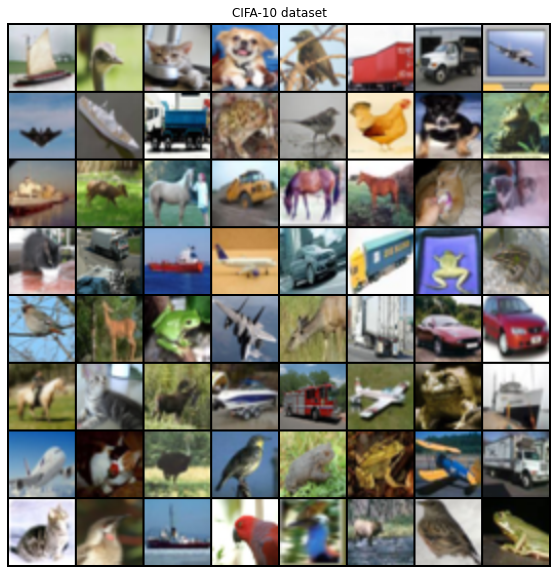

In [7]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("CIFA-10 dataset")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:BATCH_SIZE], padding=2, normalize=True).cpu(),(1,2,0)))

<h3> Model Architecture </h3>

In [9]:
class Generator(nn.Module):
    def __init__(self, num_classes, img_size,embed_size,channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            nn.ConvTranspose2d(NOISE_DIM+embed_size,features_g* 16, 4, 1, 0, bias = False),   
            self.Gnet(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self.Gnet(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self.Gnet(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )
        
        self.embed = nn.Embedding(num_classes, embed_size)

    def Gnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, embedding], dim=1)
        return self.net(x)

In [10]:
class Discriminator(nn.Module):
#     def __init__(self, channels_img, features_d):
    def __init__(self, num_classes, img_size,channels_img, features_d):    
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self.Dnet(features_d, features_d * 2, 4, 2, 1),     
            self.Dnet(features_d * 2, features_d * 4, 4, 2, 1),  
            self.Dnet(features_d * 4, features_d * 8, 4, 2, 1), 
        )
        self.validity_layer = nn.Sequential(
            nn.Conv2d(512,1,4,1,0,bias = False),
                               nn.Sigmoid())
        
        self.labels = nn.Sequential(
            nn.Conv2d(512, 11, 4, 1, 0, bias = False), 
            nn.LogSoftmax(dim = 1)
                                        )
        self.embed = nn.Embedding(num_classes, img_size*img_size)
        
        

    def Dnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            #nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
    


    def forward(self, x):
        x = self.disc(x)
        valid = self.validity_layer(x).view(-1)
        label = self.labels(x).view(-1,11)
        return valid,label

In [11]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [12]:
#Intitating instances
gen = Generator(NUM_CLASSES, IMAGE_SIZE,EMBED_SIZE,NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(NUM_CLASSES, IMAGE_SIZE,CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

In [13]:
gen.train() , disc.train()

(Generator(
   (net): Sequential(
     (0): ConvTranspose2d(200, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
     (1): Sequential(
       (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (4): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (5): Tanh()
   )
   (embed): Embedding(10, 100)
 ),
 Discriminato

<h3> Calculate fretchet distance </h3>

In [14]:
def sqrtm_approx(A, method='ss'):
    if method == 'ss':
        # Scaling and squaring method
        U, s, V = np.linalg.svd(A)
        s = np.diag(np.sqrt(s))
        return U.dot(s).dot(V)
    elif method == 'pi':
        # Power iteration method
        maxiter = 100
        tol = 1e-6
        X = np.eye(A.shape[0])
        for i in range(maxiter):
            Y = 0.5 * (X + A.dot(np.linalg.inv(X)))
            if np.max(np.abs(X - Y)) < tol:
                break
            X = Y
        return X
    else:
        raise ValueError("Invalid method: %s" % method)

In [15]:
#FID implemention#
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean = sqrtm_approx(sigma1.dot(sigma2))
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = sqrtm_approx((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

def calculate_fretchet(images_real,images_fake,model):
    mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
    mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
    """get fretched distance"""
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value


/home/psilimk/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/psilimk/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
step = 0

In [18]:
# Setup optimizers 
disOptim = optim.Adam(disc.parameters(),LEARNING_RATE, betas = (0.5,0.999))
genOptim = optim.Adam(gen.parameters(), LEARNING_RATE, betas = (0.5,0.999))
criterion = nn.BCELoss()


# Variables to track training progress
counterList = []
counter = 0
genLossList = []
disLossList = []
img_list = []

<h3> Training ACGAN </h3>

In [20]:
generator_loss = []
discriminator_loss = []
img_list = []
iters = 0
FID_list = []

print("Beginining of training...")
# start timing
time_start = time.time() 
for epoch in range(NUM_EPOCHS):
    epoch = epoch+1
    
    for batch_idx, (realImg,labels) in enumerate(dataloader):
        real = realImg.to(device)
        labels = labels.to(device)
        miniBatch = real.shape[0]
        fakeClassLabel =  10*torch.ones((miniBatch,),dtype = torch.long).to(device)        
        disc.zero_grad()
        
        # Train Discriminator
        
        r_label =  torch.full((miniBatch,), 1.0, dtype=torch.float).to(device)
        disc_real, disc_label = disc(real)
        loss_disc_realVal = criterion(disc_real, r_label)
        discRealLabelLoss = F.nll_loss(disc_label, labels) 
        realLoss_disc = loss_disc_realVal + discRealLabelLoss
        realLoss_disc.backward()
        
        sampleLabel = torch.randint(0, 10, (miniBatch,), dtype = torch.long).to(device)
        noise = torch.randn(miniBatch, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise,sampleLabel) #genrator img data
        disc_fake, disc_fLabel = disc(fake.detach())
        r_label.fill_(0.0)
        loss_disc_fakelVal = criterion(disc_fake, r_label)
        discFakeLabelLoss = F.nll_loss(disc_fLabel, fakeClassLabel) 
        fakeLoss_disc = loss_disc_fakelVal + discFakeLabelLoss
        fakeLoss_disc.backward()

        loss_disc = (realLoss_disc+fakeLoss_disc)/2
        disOptim.step()
        
        # Train Generator
        gen.zero_grad()
        noise = torch.randn(miniBatch, NOISE_DIM, 1, 1).to(device)
        sampleLabel = torch.randint(0,10,(miniBatch,),dtype = torch.long).to(device)
        r_label.fill_(1.0)
        fake = gen(noise, sampleLabel)
        genOutput, genOutputLabel = disc(fake)

        #Loss
        loss_gen_r = criterion(genOutput, r_label)
        genLabelLoss = F.nll_loss(genOutputLabel, sampleLabel)
        loss_gen = loss_gen_r + genLabelLoss
        loss_gen.backward()
        genOptim.step()
        
        generator_loss.append(loss_gen.detach().cpu())
        discriminator_loss.append(loss_disc.detach().cpu())
        
        if (iters % 500 == 0) or ((epoch == NUM_EPOCHS) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(noise,sampleLabel).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
    fretchet_dist=calculate_fretchet(real,fake,model)
    FID_list.append(fretchet_dist)
    if epoch % 5  == 0:
               print(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss Discriminator: {loss_disc:.3f}, loss Generator: {loss_gen:.3f}, FID Score: {fretchet_dist:.3f} ") 
    
    
    images = gen(noise,sampleLabel).detach()
    utils.save_image(images.detach(),'acgan_images/fake/ACGAN_epoch_%03d.png' % (epoch), normalize = True)
    
    utils.save_image(real.detach(),'acgan_images/real/ACGAN_epoch_%03d.png' % (epoch), normalize = True)
        
    
time_end = time.time()
print('\n\n Total time taken for training in ms - %.2f s.'%(time_end-time_start))

Beginining of training...
Epoch [5/50] Batch 781/782                   Loss Discriminator: 2.216, loss Generator: 3.519, FID Score: 374.221 
Epoch [10/50] Batch 781/782                   Loss Discriminator: 1.504, loss Generator: 4.114, FID Score: 329.998 
Epoch [15/50] Batch 781/782                   Loss Discriminator: 1.022, loss Generator: 6.284, FID Score: 316.682 
Epoch [20/50] Batch 781/782                   Loss Discriminator: 0.946, loss Generator: 6.685, FID Score: 354.969 
Epoch [25/50] Batch 781/782                   Loss Discriminator: 0.788, loss Generator: 6.004, FID Score: 342.675 
Epoch [30/50] Batch 781/782                   Loss Discriminator: 0.642, loss Generator: 6.483, FID Score: 356.951 
Epoch [35/50] Batch 781/782                   Loss Discriminator: 1.281, loss Generator: 6.369, FID Score: 335.792 
Epoch [40/50] Batch 781/782                   Loss Discriminator: 0.457, loss Generator: 8.214, FID Score: 321.679 
Epoch [45/50] Batch 781/782                   L

In [21]:
np.save('loss/acgan_gen_loss', generator_loss) 
np.save('loss/acgan_disc_loss', discriminator_loss) 

In [22]:
generator_loss = np.load('loss/acgan_gen_loss.npy')
discriminator_loss = np.load('loss/acgan_disc_loss.npy')

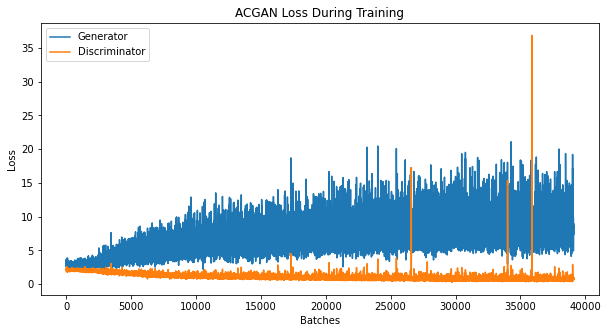

In [23]:
plt.figure(figsize=(10,5))
plt.title("ACGAN Loss During Training")
plt.plot(generator_loss,label="Generator")
plt.plot(discriminator_loss,label="Discriminator")
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.legend()
plt.show()

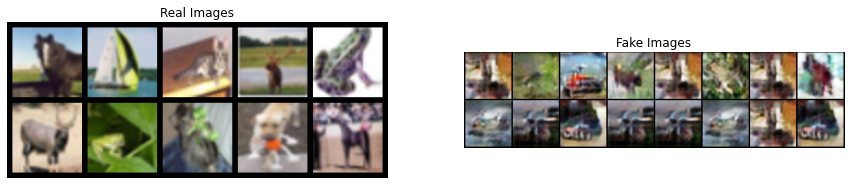

In [25]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:10], nrow=5, padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

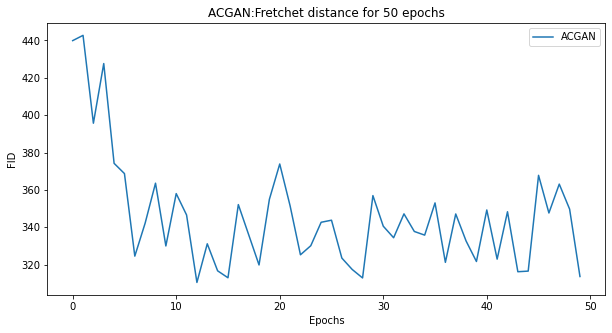

In [26]:
plt.figure(figsize=(10,5))
plt.title("ACGAN:Fretchet distance for 50 epochs")
plt.plot(FID_list,label="ACGAN")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.show()